In [1]:
import os
import sys
import json
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import torch
from torch.utils.data import DataLoader

# --- Add src directory to path (if needed) ---
# Assuming notebooks are in 'notebooks/' and src is sibling
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.data.preprocessing import calculate_normalization_stats, DeforestationDataset

STACKED_TILES_DIR = Path("../data/raw/stacked_tiles") # Or the correct path to your data
# Where to save the calculated normalization stats
STATS_OUTPUT_DIR = Path("../configs")
STATS_FILE = STATS_OUTPUT_DIR / "normalization_stats.json"
# Patch size for training
PATCH_SIZE = 256

# Define band mapping (should match the one used during download/exploration)
BAND_MAPPING = {
    'S1_VV': 0, 'S1_VH': 1, 'S2_B': 2, 'S2_G': 3, 'S2_R': 4,
    'S2_N': 5, 'S2_S1': 6, 'S2_S2': 7, 'DEM': 8, 'Label': 9
}

# Ensure output dir exists
STATS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Stacked tiles directory: {STACKED_TILES_DIR}")
print(f"Normalization stats file: {STATS_FILE}")

Stacked tiles directory: ../data/raw/stacked_tiles
Normalization stats file: ../configs/normalization_stats.json


In [2]:
all_tile_paths = sorted(list(STACKED_TILES_DIR.glob("stack_tile_*.tif")))
print(f"Total tiles found: {len(all_tile_paths)}")

if not all_tile_paths:
    raise FileNotFoundError(f"No tiles found in {STACKED_TILES_DIR}. Please check the path.")

# Split: 70% Train, 30% Temp (Val + Test)
train_paths, temp_paths = train_test_split(
    all_tile_paths, test_size=0.30, random_state=42 # Use random_state for reproducibility
)

# Split Temp: 50% Val, 50% Test (relative to temp_paths -> 15% of total each)
val_paths, test_paths = train_test_split(
    temp_paths, test_size=0.50, random_state=42 # Use same random_state for consistency
)

print(f"Train tiles: {len(train_paths)}")
print(f"Validation tiles: {len(val_paths)}")
print(f"Test tiles: {len(test_paths)}")

# Optional: Save these lists if needed later
# with open(STATS_OUTPUT_DIR / 'train_tiles.txt', 'w') as f: [f.write(f"{p}\n") for p in train_paths]
# etc.

Total tiles found: 1552
Train tiles: 1086
Validation tiles: 233
Test tiles: 233


In [3]:
# --- Define bands for normalization types (adjust if needed) ---
bands_to_standardize = ['S1_VV', 'S1_VH', 'DEM']
bands_to_scale = ['S2_B', 'S2_G', 'S2_R', 'S2_N', 'S2_S1', 'S2_S2']

# --- Calculate and Save Stats ---
print(f"\nCalculating normalization statistics using {len(train_paths)} training tiles...")

normalization_stats = calculate_normalization_stats(
    tile_paths=train_paths,
    band_mapping=BAND_MAPPING,
    bands_to_standardize=bands_to_standardize,
    bands_to_scale=bands_to_scale,
    max_tiles_for_scaling_stats=400, 
    #memory_limit_gb=2.0 
)

print(f"\nSaving normalization stats to {STATS_FILE}...")
with open(STATS_FILE, 'w') as f:
    json.dump(normalization_stats, f, indent=4)

print("Stats saved.")


Calculating normalization statistics using 1086 training tiles...
Calculating stats from 1086 tiles (using default windowed reading)...
  Will accumulate scaling values from a random sample of 400 tiles.


Processing Tiles: 100%|██████████| 1086/1086 [05:53<00:00,  3.07it/s]



Finalizing standardization statistics...
  S1_VV: Mean=-8.6559, Std=1.9534 (from 1348217428 pixels)
  S1_VH: Mean=-14.8733, Std=1.9215 (from 1348217428 pixels)
  DEM: Mean=138.4912, Std=73.2912 (from 1348217428 pixels)

Calculating percentiles (2.0, 98.0) for scaling bands (from sampled tiles)...
  Concatenating data for S2_B...
  Calculating percentiles for S2_B (496581109 pixels)...
  S2_B: Min (2.0%)=0.0246, Max (98.0%)=0.0768
  Concatenating data for S2_G...
  Calculating percentiles for S2_G (496581109 pixels)...
  S2_G: Min (2.0%)=0.0377, Max (98.0%)=0.1076
  Concatenating data for S2_R...
  Calculating percentiles for S2_R (496581109 pixels)...
  S2_R: Min (2.0%)=0.0215, Max (98.0%)=0.1287
  Concatenating data for S2_N...
  Calculating percentiles for S2_N (496581109 pixels)...
  S2_N: Min (2.0%)=0.1776, Max (98.0%)=0.3606
  Concatenating data for S2_S1...
  Calculating percentiles for S2_S1 (496581109 pixels)...
  S2_S1: Min (2.0%)=0.1236, Max (98.0%)=0.3597
  Concatenating da

In [4]:
# --- Load Saved Stats ---
print(f"Loading normalization stats from {STATS_FILE}...")
with open(STATS_FILE, 'r') as f:
    loaded_stats = json.load(f)

# --- Instantiate Datasets ---
# Use a small subset of validation paths for quick demonstration
demo_paths = val_paths[:min(5, len(val_paths))]

print("\nInstantiating Dataset (Validation Set Sample, No Augmentation)...")
val_dataset_demo = DeforestationDataset(
    tile_paths=demo_paths,
    band_mapping=BAND_MAPPING,
    normalization_stats=loaded_stats,
    patch_size=PATCH_SIZE,
    augment=False # No augmentation for validation/testing demo
)

print("Instantiating Dataset (Training Set Sample, With Augmentation)...")
train_dataset_demo = DeforestationDataset(
    tile_paths=train_paths[:min(5, len(train_paths))], # Use a few train paths
    band_mapping=BAND_MAPPING,
    normalization_stats=loaded_stats,
    patch_size=PATCH_SIZE,
    augment=True # Enable augmentation for training demo
)

# --- Create DataLoaders ---
# Batch size 1 for easy visualization of single samples
val_loader_demo = DataLoader(val_dataset_demo, batch_size=1, shuffle=False)
train_loader_demo = DataLoader(train_dataset_demo, batch_size=1, shuffle=True)

print(f"\nDataset size (demo): {len(val_dataset_demo)}")

Loading normalization stats from ../configs/normalization_stats.json...

Instantiating Dataset (Validation Set Sample, No Augmentation)...
Dataset initialized with 5 tiles.
One epoch will consist of 50 random patches.
Pre-checking tile dimensions...


Checking Tiles: 100%|██████████| 5/5 [00:00<00:00, 182.71it/s]


Found 5 tiles suitable for patch size 256.
Instantiating Dataset (Training Set Sample, With Augmentation)...
Dataset initialized with 5 tiles.
One epoch will consist of 50 random patches.
Pre-checking tile dimensions...


Checking Tiles: 100%|██████████| 5/5 [00:00<00:00, 1038.14it/s]

Found 5 tiles suitable for patch size 256.

Dataset size (demo): 50



Visualizing one sample from Validation DataLoader (Normalized, No Augmentation)...
Features shape: (9, 256, 256), Label shape: (256, 256)
Features dtype: float32, Label dtype: int64
Features min/max: -4.79/2.52
Label unique values: [0 1]


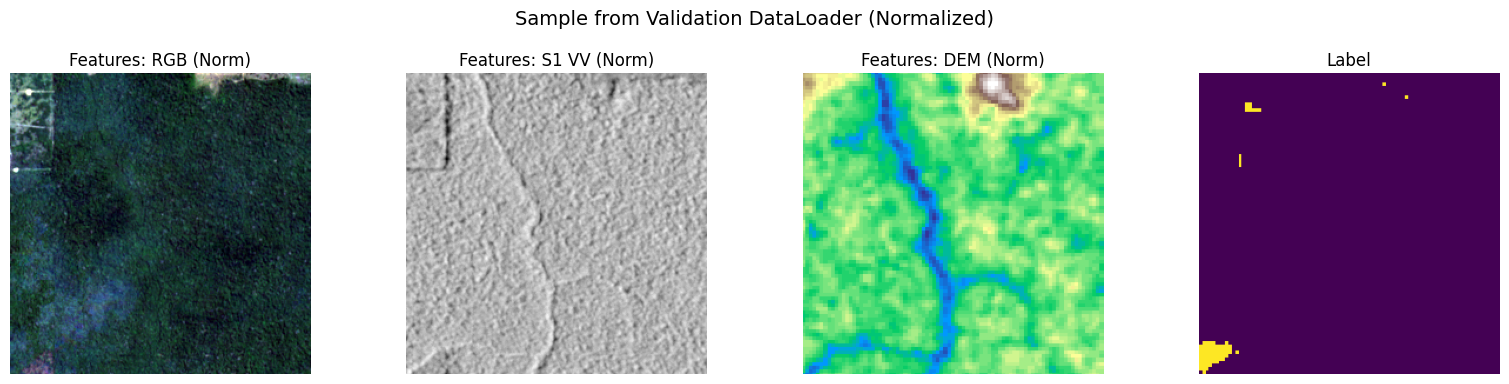


Visualizing one sample from Training DataLoader (Normalized + Augmented)...


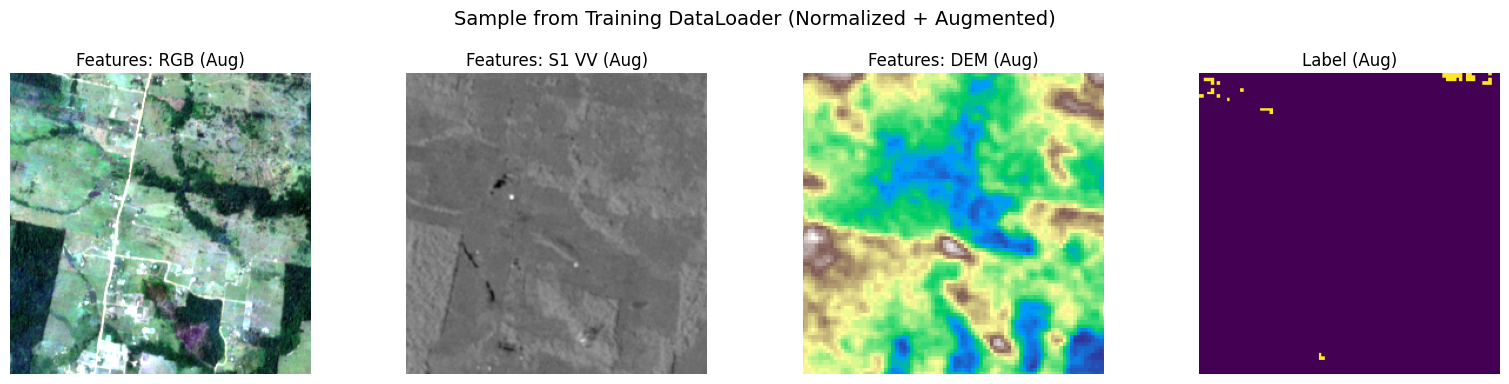

In [7]:
# --- Visualize a Sample from DataLoader ---

print("\nVisualizing one sample from Validation DataLoader (Normalized, No Augmentation)...")
features, label = next(iter(val_loader_demo)) # Get first batch (size 1)

# Squeeze batch dimension (since batch_size=1)
features = features.squeeze(0).numpy() # Shape: (C, H, W)
label = label.squeeze(0).numpy()       # Shape: (H, W)

print(f"Features shape: {features.shape}, Label shape: {label.shape}")
print(f"Features dtype: {features.dtype}, Label dtype: {label.dtype}")
print(f"Features min/max: {features.min():.2f}/{features.max():.2f}") # Check normalization effect
print(f"Label unique values: {np.unique(label)}")

# Visualize components (Example: RGB, S1_VV, DEM, Label)
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Sample from Validation DataLoader (Normalized)", fontsize=14)

# --- RGB ---
# Need to find the indices within the *feature* tensor now
feature_band_names = [k for k, v in BAND_MAPPING.items() if k != 'Label']
s2r_idx_f = feature_band_names.index('S2_R')
s2g_idx_f = feature_band_names.index('S2_G')
s2b_idx_f = feature_band_names.index('S2_B')

# Extract RGB bands, transpose C,H,W -> H,W,C for imshow
rgb_display = features[[s2r_idx_f, s2g_idx_f, s2b_idx_f], :, :].transpose(1, 2, 0)
# Values should be roughly 0-1 after scaling, but clip just in case
rgb_display = np.clip(rgb_display, 0, 1)
axes[0].imshow(rgb_display)
axes[0].set_title("Features: RGB (Norm)")
axes[0].axis('off')

# --- S1 VV ---
s1vv_idx_f = feature_band_names.index('S1_VV')
s1vv_display = features[s1vv_idx_f, :, :]
# Standardized data might be outside 0-1, adjust display range or clip
# vmin, vmax = np.percentile(s1vv_display, [2, 98]) # Stretch for display
axes[1].imshow(s1vv_display, cmap='gray') #, vmin=vmin, vmax=vmax)
axes[1].set_title("Features: S1 VV (Norm)")
axes[1].axis('off')

# --- DEM ---
dem_idx_f = feature_band_names.index('DEM')
dem_display = features[dem_idx_f, :, :]
axes[2].imshow(dem_display, cmap='terrain')
axes[2].set_title("Features: DEM (Norm)")
axes[2].axis('off')

# --- Label ---
axes[3].imshow(label, cmap='viridis', vmin=0, vmax=1)
axes[3].set_title("Label")
axes[3].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Visualize Augmented Sample ---
print("\nVisualizing one sample from Training DataLoader (Normalized + Augmented)...")
features_aug, label_aug = next(iter(train_loader_demo))
features_aug = features_aug.squeeze(0).numpy()
label_aug = label_aug.squeeze(0).numpy()

# (Repeat visualization code block above, using features_aug, label_aug)
# ... visualization code ...
# This will show the effect of random flips if they occurred.
# (Code omitted for brevity, copy/paste the visualization block above)
fig_aug, axes_aug = plt.subplots(1, 4, figsize=(16, 4))
fig_aug.suptitle("Sample from Training DataLoader (Normalized + Augmented)", fontsize=14)
rgb_display_aug = features_aug[[s2r_idx_f, s2g_idx_f, s2b_idx_f], :, :].transpose(1, 2, 0)
rgb_display_aug = np.clip(rgb_display_aug, 0, 1)
axes_aug[0].imshow(rgb_display_aug); axes_aug[0].set_title("Features: RGB (Aug)"); axes_aug[0].axis('off')
s1vv_display_aug = features_aug[s1vv_idx_f, :, :]
axes_aug[1].imshow(s1vv_display_aug, cmap='gray'); axes_aug[1].set_title("Features: S1 VV (Aug)"); axes_aug[1].axis('off')
dem_display_aug = features_aug[dem_idx_f, :, :]
axes_aug[2].imshow(dem_display_aug, cmap='terrain'); axes_aug[2].set_title("Features: DEM (Aug)"); axes_aug[2].axis('off')
axes_aug[3].imshow(label_aug, cmap='viridis', vmin=0, vmax=1); axes_aug[3].set_title("Label (Aug)"); axes_aug[3].axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [14]:
# --- 4. Save Data Splits to Files ---
project_root = Path("..") # Adjust if needed
# Define output directory for split files
SPLIT_DIR = Path("../data/processed/splits") # Or adjust path as needed
SPLIT_DIR.mkdir(parents=True, exist_ok=True)

# Define output file paths
TRAIN_LIST_FILE = SPLIT_DIR / "train_tiles.txt"
VAL_LIST_FILE = SPLIT_DIR / "val_tiles.txt"
TEST_LIST_FILE = SPLIT_DIR / "test_tiles.txt"

print(f"\nSaving data splits to {SPLIT_DIR}...")

def save_paths_to_file(filepath: Path, paths: list, project_root: Path):
    """
    Writes a list of Path objects to a file, saving paths
    relative to the specified project_root.
    """
    print(f"Saving {len(paths)} paths relative to {project_root} into {filepath}...")
    count = 0
    with open(filepath, 'w') as f:
        for p in paths:
            try:
                # Calculate path relative to project root
                relative_p = p.relative_to(project_root)
                f.write(f"{str(relative_p)}\n") # Write the relative path string
                count += 1
            except ValueError:
                 print(f"  Warning: Cannot make path relative - {p}. Skipping.")
            except Exception as e:
                 print(f"  Warning: Error processing path {p}: {e}. Skipping.")
    print(f"Successfully saved {count} relative paths to {filepath}")

# Assuming train_paths, val_paths, test_paths are defined from previous cells
save_paths_to_file(TRAIN_LIST_FILE, train_paths, project_root)
save_paths_to_file(VAL_LIST_FILE, val_paths, project_root)
save_paths_to_file(TEST_LIST_FILE, test_paths, project_root)

print("\nData split file paths saved.")



Saving data splits to ../data/processed/splits...
Saving 1086 paths relative to .. into ../data/processed/splits/train_tiles.txt...
Successfully saved 1086 relative paths to ../data/processed/splits/train_tiles.txt
Saving 233 paths relative to .. into ../data/processed/splits/val_tiles.txt...
Successfully saved 233 relative paths to ../data/processed/splits/val_tiles.txt
Saving 233 paths relative to .. into ../data/processed/splits/test_tiles.txt...
Successfully saved 233 relative paths to ../data/processed/splits/test_tiles.txt

Data split file paths saved.
